In [1]:
import os
import tweepy

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

t_consumer_key    = os.environ.get('t_consumer_key')
t_consumer_secret = os.environ.get('t_consumer_secret')
t_bearer_token    = os.environ.get('t_bearer_token')
t_access_token    = os.environ.get('t_access_token')
t_access_secret   = os.environ.get('t_access_secret')

# Twitter API

In [2]:
day = 274
wordle_day = 'Wordle ' + str(day)

client = tweepy.Client(t_bearer_token)
#client.search_recent_tweets('covid OR covid19 is:retweet -is:retweet has:media -has:media from:x')

query = wordle_day + ' -is:retweet'
#response = tweepy.Paginator(client.search_recent_tweets, query=query, max_results=10).flatten(limit=10)

tweets = client.search_recent_tweets(query=query, max_results=100)

# Parse Tweet

Guess #1  &emsp;  ⬛⬛⬛🟩⬛  &emsp;  1  &emsp;  green    &emsp;  0  &emsp;  yellow  <br>
Guess #2  &emsp;  🟨⬛⬛🟩⬛  &emsp;  1  &emsp;  green    &emsp;  1  &emsp;  yellow  <br>
Guess #3  &emsp;  🟨🟨⬛🟩⬛  &emsp;  1  &emsp;  green    &emsp;  2  &emsp;  yellow  <br>
Guess #4  &emsp;  ⬛🟨🟨🟩🟨  &emsp;  1  &emsp;  green    &emsp;  3  &emsp;  yellow  <br>
Guess #5  &emsp;  🟩🟩🟩🟩🟩  &emsp;  5  &emsp;  green    &emsp;  0  &emsp;  yellow  <br>
Guess #6  &emsp;  N/A &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; N/A  &emsp;&emsp;&emsp;&emsp;    N/A

In [48]:
def API_to_DF(tweets):
    df = pd.DataFrame(columns = ['completion', '#1_G', '#1_Y', '#2_G', '#2_Y', '#3_G', '#3_Y',
                                           '#4_G', '#4_Y', '#5_G', '#5_Y', '#6_G', '#6_Y'])
    for tweet in tweets.data:
        df = df.reindex(df.index.tolist() + list(range(df.shape[0], df.shape[0]+1)))

        # find the (start, end) of grid and extract grid
        temp = [tweet.text.find('⬛'),tweet.text.find('⬜'),tweet.text.find('🟨'),tweet.text.find('🟩')]
        if sum(temp) == -4:
            pass
        else:
            l = min([i for i in temp if i >= 0])
        r = max(tweet.text.rfind('⬛'), tweet.text.rfind('⬜'), tweet.text.rfind('🟨'), tweet.text.rfind('🟩'))
        grid = tweet.text[l: r+1]

        # grid max: 6*6=36. ignore tweets that have added additional wordle boxes
        if (len(grid) +1) <= 36:

            # store attempt in which the wordle was completed
            df.iloc[-1, 0] = tweet.text[tweet.text.find('/6') - 1]

            # parse through each guess of the wordle grid. tally green and yellow quantities
            col = 1
            guess_start = 0
            grid_len = len(grid)

            while guess_start < grid_len:        
                guess = grid[guess_start: guess_start+5]

                df.iloc[-1, col]   = guess.count('🟩')
                df.iloc[-1, col+1] = guess.count('🟨') 

                col += 2
                guess_start += 6
                
    df = df[df['#1_G'].notnull()]
    #df = df.astype({'#1_G':'float64','#1_Y':'float64','#2_G':'float64','#2_Y':'float64','#3_G':'float64','#3_Y':'float64',
    #                '#4_G':'float64','#4_Y':'float64','#5_G':'float64','#5_Y':'float64','#6_G':'float64','#6_Y':'float64'})
    return df

# train-test split
df = API_to_DF(tweets)
split = int(0.80*df.shape[0])
trn = df.iloc[:split, :]
tst = df.iloc[split:, :]

In [ ]:
#temp = df['completion'].value_counts()
#temp.plot(kind='bar').savefig('here.png')

counts = df['completion'].value_counts().reindex(['1','2','3','4','5','6','X'], fill_value = 0 )

plt.bar(counts.index.values, height=counts.values, color='blue', edgecolor='black')
plt.title('Wordle Completion Attempts \n' + wordle_day)
plt.xlabel('# of Attempts')





#plt.savefig('Second Attempt Results.png', bbox_inches='tight')

print(df)
#print(response)

#auth = tweepy.OAuthHandler(API_key, API_secret_key)
#auth.set_access_token(auth)

# Multiclass Logistic Regression

In [29]:
lr = LogisticRegression(multi_class='multinomial')

y_trn = trn['completion']
x_trn = trn[['#1_G','#1_Y']]

y_tst = tst['completion']
x_tst = tst[['#1_G','#1_Y']]

lr.fit(x_trn, y_trn)

y_trn_hat = lr.predict(x_trn)
print('Train Accuracy: ', round(100*accuracy_score(y_trn, y_trn_hat), 2), '%')


y_tst_hat = lr.predict(x_tst)
print('Test Accuracy: ', round(100*accuracy_score(y_tst, y_tst_hat), 2), '%')

Train Accuracy:  38.75 %
Test Accuracy:  45.0 %


# XGBoost

In [49]:
trn.head()

,completion,#1_G,#1_Y,#2_G,#2_Y,#3_G,#3_Y,#4_G,#4_Y,#5_G,#5_Y,#6_G,#6_Y
0,4,0,0,0,0,1,0,5,0,NaN,NaN,NaN,NaN
1,5,1,0,0,0,2,1,4,0,5,0,NaN,NaN
2,5,0,0,0,3,0,3,0,3,5,0,NaN,NaN
3,4,0,2,2,0,3,0,5,0,NaN,NaN,NaN,NaN
4,3,1,0,2,0,5,0,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# one-hot encoding of the categorical
trn = pd.get_dummies(trn, columns=['completion'])
#trn = df.astype({'#1_G':'float64','#1_Y':'float64','#2_G':'float64','#2_Y':'float64','#3_G':'float64','#3_Y':'float64',
#                '#4_G':'float64','#4_Y':'float64','#5_G':'float64','#5_Y':'float64','#6_G':'float64','#6_Y':'float64'})
#x_trn_e = pd.get_dummies(x_trn, columns=['completion'])
#y_trn_e = pd.get_dummies(y_trn, columns=['completion'])
trn.head()
#x_trn_e.head()

,#1_G,#1_Y,#2_G,#2_Y,#3_G,#3_Y,#4_G,#4_Y,#5_G,#5_Y,#6_G,#6_Y,completion_2,completion_3,completion_4,completion_5,completion_6
0,0,0,0,0,1,0,5,0,NaN,NaN,NaN,NaN,0,0,1,0,0
1,1,0,0,0,2,1,4,0,5,0,NaN,NaN,0,0,0,1,0
2,0,0,0,3,0,3,0,3,5,0,NaN,NaN,0,0,0,1,0
3,0,2,2,0,3,0,5,0,NaN,NaN,NaN,NaN,0,0,1,0,0
4,1,0,2,0,5,0,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0


In [21]:
model = XGBClassifier(objective='multi:softmax')
model.fit =(x_trn, y_trn)
#print(xgb)



In [8]:

lr.predict(x_trn)
#print('Train Accuracy: ', round(100*accuracy_score(y_trn, y_pred), 2), '%')

array(['6', '5', '6', '3', '5', '6', '5', '6', '3', '5', '5', '3', '5',
       '5', '5', '5', '5', '5', '5', '3', '5', '5', '5', '5', '6', '5',
       '5', '3', '5', '5', '5', '6', '5', '5', '5', '5', '5', '3', '5',
       '6', '5', '6', '5', '3', '5', '3', '5', '3', '3', '5', '5', '3',
       '5', '6', '5', '5', '6', '5', '5', '5', '5', '5', '6', '6', '5',
       '6', '3', '5', '5', '3', '6', '5', '5', '5', '5', '5', '6', '3',
       '5', '5'], dtype=object)

In [220]:
#x_tst = np.array([0,0])#.reshape((-1, 1))
x_tst = pd.DataFrame([{'#1_G':0, '#1_Y':0}])



print(y_pred)

['4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '2' '4' '2' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '2' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4'
 '4' '2' '1' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '4' '2'
 '4' '4' '4' '4' '4' '4' '4' '4' '4' '4']
0.38


In [120]:
lr.predict(pd.DataFrame([{'#1_G':5, '#1_Y':0}]))

array(['1'], dtype=object)

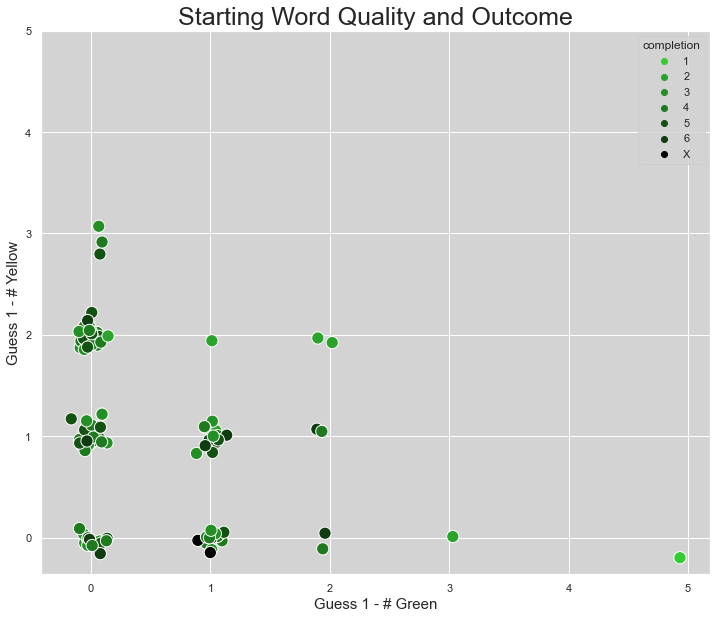

In [215]:
def jitter(x, jitter):
    return x + np.random.normal(loc=0, scale=jitter, size=x.shape)

sns.set(rc={'axes.facecolor':'lightgray', 'figure.figsize':(12,10)})
palette = {'1':'#33cc33', '2':'#29a329', '3':'#248f24', '4':'#1f7a1f', '5':'#145214', '6':'#0f3d0f', 'X':'#000000'}
hue_order = ['1','2','3','4','5','6','X']

plot = sns.scatterplot(x=jitter(df['#1_G'], 0.08), y=jitter(df['#1_Y'], 0.08), 
                       hue=df['completion'], palette=palette, hue_order=hue_order, s=150)

plot.set_xlabel('Guess 1 - # Green', fontsize=15)
plot.set_ylabel('Guess 1 - # Yellow', fontsize=15)
plot.set_title('Starting Word Quality and Outcome', fontsize=25)

plt.xticks([0,1,2,3,4,5])
plt.yticks([0,1,2,3,4,5])
plt.show(plot)